## Initial configuration

In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import cv2
import gc
from tqdm import tqdm,trange

import torch
from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

import urllib.request
import zipfile
import json

import gdown

from collections import Counter

In [3]:
#Usefull for better outputs visualization
PURPLE = "\033[95m"
CYAN = "\033[96m"
DARKCYAN = "\033[36m"
BLUE = "\033[94m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"
END = "\033[0m"

### Project settings

In [51]:
data_dir_unsplitted = "dataset/unsplitted"
save_dir_splitted = "dataset/splitted"
data_dir = "dataset/splitted"
models_dir ="models/" #the resuls will be saved here

os.makedirs(models_dir,exist_ok=True)

np.random.seed(42) 

patch_size = 128
n_samples_train = 40
n_samples_valtest = 40
batch_size = 75

mse_weight = 0


grayscale= False
resize_to= None
fft = False


learning_rate= 0.001
num_epochs = 70


LOAD_DATASET = True
DATASET_ALREADY_DOWNLOADED = True 
DATASET_ALREADY_UNZIPPED = True

LOAD_MODEL = True #the models load was trained with a value of mse_weight = 50 and for comparison with mse_weight = 0
MODEL_ALREADY_DOWNLOADED = False
MODEL_ALREADY_UNZIPPED = False

## Dataset preparation

### Dataset splitting and data augmentation

In [52]:
classes = ["CLL", "FL", "MCL"]
id_to_name = {0:"CLL",1:"FL",2:"MCL"}
name_to_id = {"CLL":0,"FL":1,"MCL":2}

if(not LOAD_DATASET):
    data = []
    labels = []
    for i, cl in enumerate(classes):
        path = os.path.join(data_dir_unsplitted, cl)
        images = os.listdir(path)
        for img in tqdm(images,desc=cl):
            img_path = os.path.join(path, img)
            img = cv2.imread(img_path).astype(np.uint8)
            
            data.append(img)
            labels.append(i) 


    data = np.array(data)
    labels = np.array(labels)


    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.125, random_state=42)

    print("Train samples:", len(train_data))
    print("Test samples:", len(test_data))
    print("Validation samples:", len(val_data))

### Saving the splitted dataset

In [53]:
def crop_image(image, patch_size, n_samples = 40):
    h, w, _ = image.shape
    h_eff = h - patch_size
    w_eff = w - patch_size
    samples = []
    
    for i in range(n_samples):
        h_vertex = np.random.randint(h_eff)
        w_vertex = np.random.randint(w_eff)
        samples.append(image[h_vertex:h_vertex+patch_size, w_vertex:w_vertex+patch_size, :])
    
    samples = np.stack(samples)
    return samples   

In [54]:
#SAVING THE DATASET
if(not LOAD_DATASET):
    #TRAIN
    os.makedirs(os.path.join(save_dir_splitted,"train","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","labels_patch"),exist_ok=True)
     
    train_labels_dict={}
    train_labels_patch_dict={}
    
    for i, image in enumerate(tqdm(train_data,desc = "Train")):                       #images
        file_name = str(i)+"_train"+".png"
        
        path = os.path.join(save_dir_splitted,"train","images",file_name)
        train_labels_dict[file_name] = int(train_labels[i])
        cv2.imwrite(path,image.astype(np.float64))
        
        image_patch = crop_image(image, patch_size, n_samples_train)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_train"+".png"
            path = os.path.join(save_dir_splitted,"train","images_patch",file_name)
            train_labels_patch_dict[file_name] = int(train_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))
       
    
    
    with open(os.path.join(save_dir_splitted,"train","labels","train.json"), 'w') as f:
        json.dump(train_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"train","labels_patch","train_patch.json"), 'w') as f:
        json.dump(train_labels_patch_dict, f)#labels

    #TEST
    os.makedirs(os.path.join(save_dir_splitted,"test","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","labels_patch"),exist_ok=True)

    test_labels_dict={}
    test_labels_patch_dict={}
    
    for i, image in enumerate(tqdm(test_data,desc = "Test")):                      #images
        file_name = str(i)+"_test"+".png"
        path = os.path.join(save_dir_splitted,"test","images",file_name)
        
        cv2.imwrite(path,image.astype(np.float64))
        test_labels_dict[file_name] = int(test_labels[i]) 
        
        image_patch = crop_image(image, patch_size, n_samples_valtest)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_test"+".png"
            path = os.path.join(save_dir_splitted,"test","images_patch",file_name)
            test_labels_patch_dict[file_name] = int(test_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))

    with open(os.path.join(save_dir_splitted,"test","labels","test.json"), 'w') as f:
        json.dump(test_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"test","labels_patch","test_patch.json"), 'w') as f:
        json.dump(test_labels_patch_dict, f)#labels
        
    #VALIDATION
    os.makedirs(os.path.join(save_dir_splitted,"val","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","labels_patch"),exist_ok=True)
    
    val_labels_dict = {}
    val_labels_patch_dict = {}
    
    for i, image in enumerate(tqdm(val_data,desc = "Validation")):               #images
        file_name = str(i)+"_val"+".png"
        path = os.path.join(save_dir_splitted,"val","images",file_name)
        
        cv2.imwrite(path,image.astype(np.float64))
        val_labels_dict[file_name] = int(val_labels[i])
        
        image_patch = crop_image(image, patch_size, n_samples_valtest)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_val"+".png"
            path = os.path.join(save_dir_splitted,"val","images_patch",file_name)
            val_labels_patch_dict[file_name] = int(val_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))
        
    with open(os.path.join(save_dir_splitted,"val","labels","val.json"), 'w') as f:
        json.dump(val_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"val","labels_patch","val_patch.json"), 'w') as f:
        json.dump(val_labels_patch_dict, f)#labels

### Dataloaders definition

Notice that the labels are saved into a numpy array, while the images are read directly from the folder

In [55]:
class HDAdataset(Dataset):
    def __init__(self, root_dir, labels, train = False, transform=None, grayscale= False, resize_to= None, fft = False):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        self.train = train
        self.grayscale=grayscale
        self.fft = fft
        self.resize_to = resize_to

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        if self.grayscale or self.fft:
            image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            
        else:
            image = cv2.imread(img_path)

        
        if self.train:
            image = image.astype(np.uint8) + np.random.normal(0, 2, image.shape).astype(np.uint8)
        
        if self.resize_to is not None:
            image = cv2.resize(image, resize_to, interpolation= cv2.INTER_LINEAR)
            
        if self.fft:
            image = np.fft.fft2(image)
            fshift = np.fft.fftshift(image)
            magnitude_spectrum = 20*np.log(np.abs(fshift))
            image = magnitude_spectrum
        

    
        #labels smoothing
        label = 0.1*np.ones(3)
        label[self.labels[img_name]] = 0.8
        
        if self.transform:
            image = self.transform((image/255.).astype(np.float32))

        return image, label

In [56]:
class HDAdatasetPatches(Dataset):
    def __init__(self, root_dir,patch_dir, labels, train = False, grayscale= False, fft = False):
        self.root_dir = root_dir
        self.patch_dir = patch_dir
        self.labels = labels
        self.train = train
        self.grayscale=grayscale
        self.fft = fft

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img_id = int(img_name.split("_")[0])
        
        patches_list = os.listdir(self.patch_dir)
        patches_image_list = list(filter(lambda name: int(name.split("-")[0]) == img_id, patches_list))
        
        all_patches = []
        
        full_image = cv2.imread(os.path.join(self.root_dir,img_name))
        full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
        
        for patch in patches_image_list:
            patch_path = os.path.join(self.patch_dir, patch)
            

            if self.grayscale or self.fft:
                image = cv2.imread(patch_path,cv2.IMREAD_GRAYSCALE)
                
                channels = 1
            
            else:
                image = cv2.imread(patch_path)
                channels = 3

            if self.train:
                image = image.astype(np.uint8) + np.random.normal(0, 2, image.shape).astype(np.uint8)

            if self.fft:
                image = np.fft.fft2(image)
                fshift = np.fft.fftshift(image)
                magnitude_spectrum = 20*np.log(np.abs(fshift))
                image = magnitude_spectrum
            
            image = (image/255.).astype(np.float32)
            image = image.reshape(image.shape[0],image.shape[1],channels)
            image = np.transpose(image, (2, 0, 1))
            all_patches.append(image.reshape(1,image.shape[0],image.shape[1],image.shape[2]))

        all_patches=np.stack(all_patches)
        
        #labels smoothing
        label = 0.1*np.ones(3)
        label[self.labels[img_name]] = 0.8

        return all_patches, label.reshape(1,label.shape[0]), full_image

In [57]:
if(LOAD_DATASET):
    
    if(not (DATASET_ALREADY_DOWNLOADED or DATASET_ALREADY_UNZIPPED)):
        print(BOLD+"Download and the dataset"+END)
        
        url = 'https://drive.google.com/u/0/uc?id=1gz9yCLtRA7Do9Or1M4z0q9IojLMJBie0&export=download'
        output = 'dataset.zip'
        gdown.download(url, output, quiet=False)
        
    if(not DATASET_ALREADY_UNZIPPED):
        print(BOLD+"Extract the dataset"+END)
        
        with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
            zip_ref.extractall("./dataset/")

        
#convert to tensor each image
transform = transforms.Compose([transforms.ToTensor()])    


#TRAIN DATASET AND DATALOADER
train_dir = os.path.join(data_dir,"train","images_patch")#images
train_labels_dir = os.path.join(data_dir,"train","labels_patch","train_patch.json")
with open(train_labels_dir) as f:
    train_labels = json.load(f)#labels

    
if(not LOAD_MODEL): #useless dataloader if you dedice to download the pre-trained model
    train_dataset = HDAdataset(train_dir,train_labels,train = True, transform=transform
                               ,grayscale=grayscale,fft=fft)

    #using a list to increase the training speed since the data fit in the ram
    train_data = [data for data in tqdm(train_dataset,desc="Generating the train set list")] 

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)


#TEST DATASET
test_dir = os.path.join(data_dir,"test","images")#images
test_dir_patches = os.path.join(data_dir,"test","images_patch")#patches
test_labels_dir = os.path.join(data_dir,"test","labels","test.json")
with open(test_labels_dir) as f:
    test_labels = json.load(f)#labels

test_dataset = HDAdatasetPatches(test_dir,test_dir_patches,test_labels,train = False,
                          grayscale=grayscale,fft=fft)


#VALIDATION DATASET
val_dir = os.path.join(data_dir,"val","images")#images
val_dir_patches = os.path.join(data_dir,"val","images_patch")#patches
val_labels_dir = os.path.join(data_dir,"val","labels","val.json")
with open(val_labels_dir) as f:
    val_labels = json.load(f)#labels

val_dataset = HDAdatasetPatches(val_dir,val_dir_patches,val_labels,train = False,
                          grayscale=grayscale,fft=fft)

### Input example

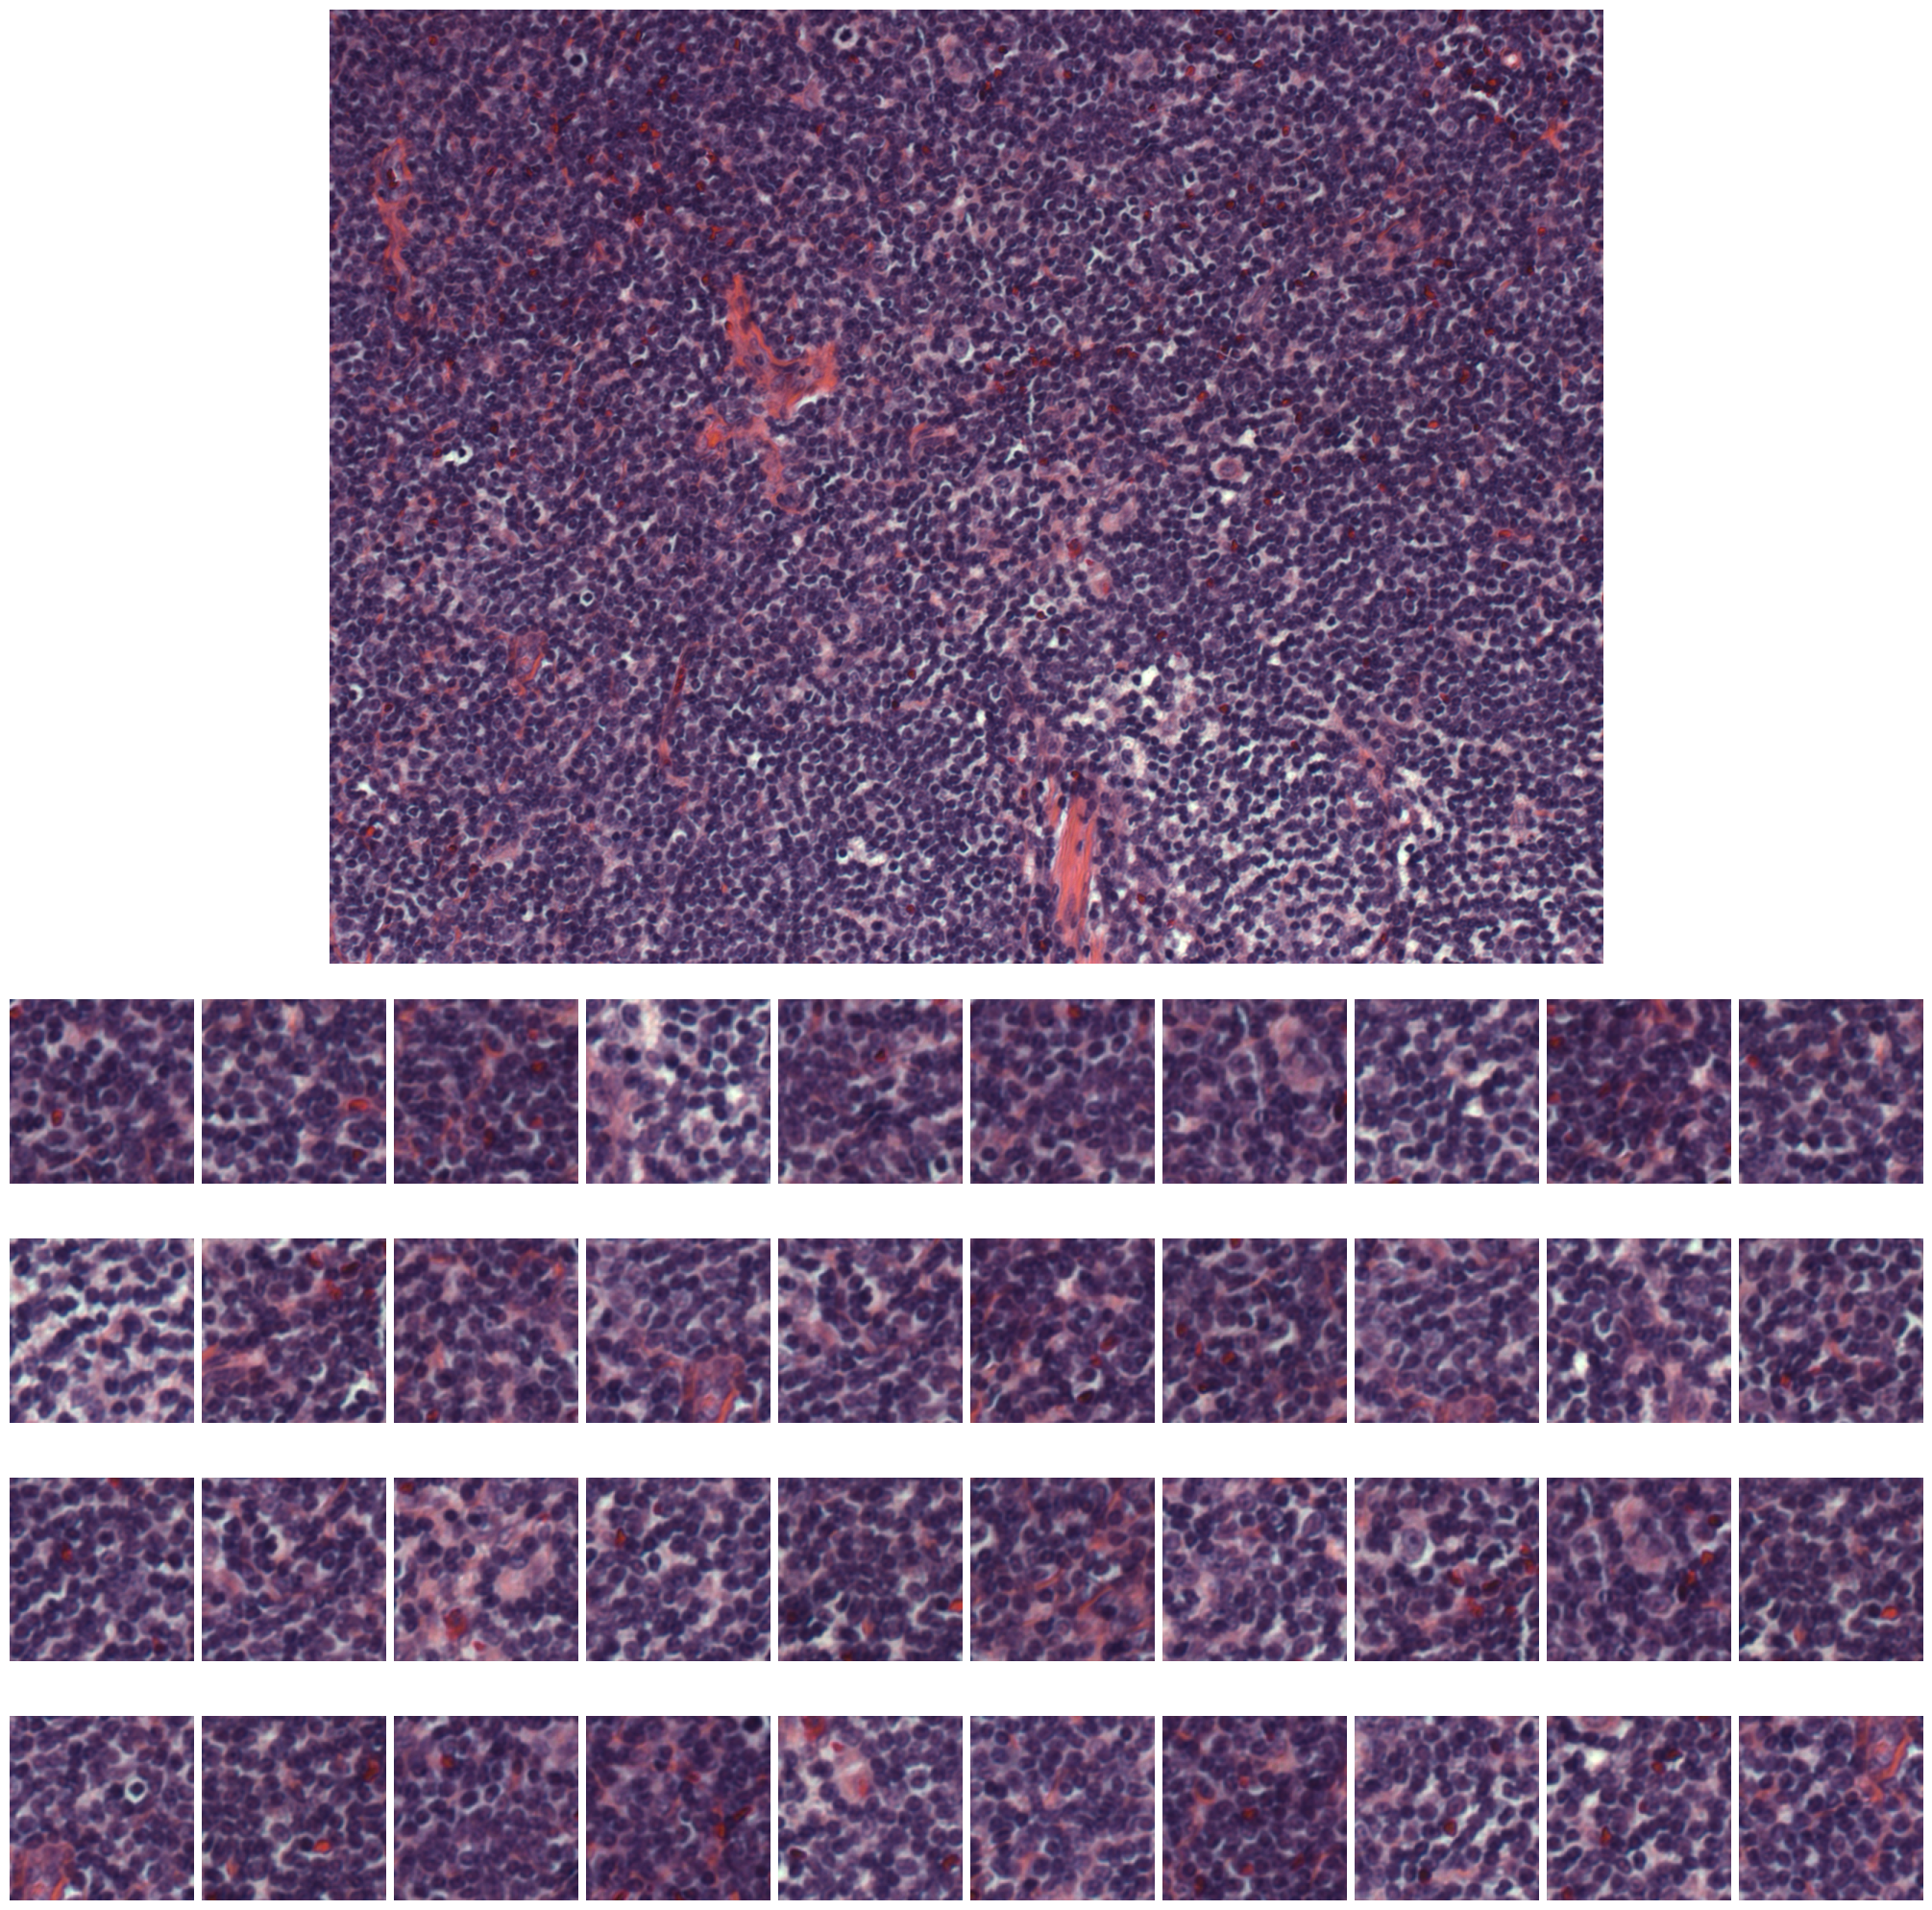

In [58]:
ids = 45

fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = fig.add_gridspec(2,10)

ax = fig.add_subplot(gs[0,:])
ax.axis('off')
ax.imshow(test_dataset[ids][2])

gs2 = gs[1,:].subgridspec(4,10)

for i,data in enumerate(test_dataset[ids][0]):
    ax = fig.add_subplot(gs2[i])
    ax.axis('off')
    imagergb = cv2.cvtColor(data.reshape(3,128,128).transpose(1,2,0), cv2.COLOR_BGR2RGB)
    ax.imshow(imagergb)

## Neural network

In [59]:
torch.cuda.empty_cache()
gc.collect()

94340

### Models definition

In [60]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #encoder
        self.convE1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convE2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convE3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.flatten = nn.Flatten()
        self.BNE16 = nn.BatchNorm2d(16)
        self.BNE32 = nn.BatchNorm2d(32)
        self.BNE64 = nn.BatchNorm2d(64)
        self.linearE1 = nn.Linear(14400,50)
        self.linearE2 = nn.Linear(50,3)
        self.BNE150linear = nn.BatchNorm1d(50)
        
        self.act = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.1)
        
        #decoder
        
        self.convD1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convD2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convD3 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=(3,3), 
                                         stride=(2,2), padding=(0,0), dilation=1,output_padding=(1,1))
        self.reshape = nn.Unflatten(-1, (64,15,15))
        self.BND16 = nn.BatchNorm2d(16)
        self.BND32 = nn.BatchNorm2d(32)
        self.linearD1 = nn.Linear(3,50)
        self.linearD2 = nn.Linear(50,14400)
        self.BND150linear = nn.BatchNorm1d(50)
        self.BND16klinear = nn.BatchNorm1d(14400)
        
        self.out = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):

        x1 = self.act(self.BNE16(self.convE1(x)))
        x2 = self.act(self.BNE32(self.convE2(x1)))
        x3 = self.act(self.BNE64(self.convE3(x2)))
        x3linear = self.flatten(x3)
        x4 = self.drop(self.act(self.BNE150linear(self.linearE1(x3linear))))
        x5 = self.linearE2(x4)

        x = self.act(self.BND150linear(self.linearD1(x5)))
        x = self.act(self.BND16klinear(self.linearD2(x+x4)))
        x = self.reshape(x)
        x = self.act(self.BND32(self.convD1(x+x3)))
        x = self.act(self.BND16(self.convD2(x+x2)))
        x = self.out(self.convD3(x+x1))

        return x,self.softmax(x5)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(BOLD+"You are working on: "+END+str(device))

You are working on: cuda


### Loading of the models

In [63]:
if(LOAD_MODEL):
    
    if(not (MODEL_ALREADY_DOWNLOADED or MODEL_ALREADY_UNZIPPED)):
        print(BOLD+"Download the model"+END)
        
        url = 'https://drive.google.com/u/0/uc?id=13grwNiSwz6UrG2B6JHBTMb_ApHi2ipnV&export=download'
        output = 'models.zip'
        gdown.download(url, output, quiet=False)
        
    if(not MODEL_ALREADY_UNZIPPED):
        
        print(BOLD+"Extract the model"+END)
        
        with zipfile.ZipFile("models.zip", 'r') as zip_ref:
            zip_ref.extractall("./models/")

Download the model


Downloading...
From: https://drive.google.com/u/0/uc?id=13grwNiSwz6UrG2B6JHBTMb_ApHi2ipnV&export=download
To: C:\Users\Gianpietro\Desktop\HDA-project\models.zip
100%|█████████████████████████████████████████████████████████████████████████████| 7.97M/7.97M [00:00<00:00, 20.1MB/s]


Extract the model


In [64]:
autoencoder = Autoencoder().to(device)
summary(autoencoder, (3, 128, 128), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [75, 16, 63, 63]             448
       BatchNorm2d-2           [75, 16, 63, 63]              32
         LeakyReLU-3           [75, 16, 63, 63]               0
            Conv2d-4           [75, 32, 31, 31]           4,640
       BatchNorm2d-5           [75, 32, 31, 31]              64
         LeakyReLU-6           [75, 32, 31, 31]               0
            Conv2d-7           [75, 64, 15, 15]          18,496
       BatchNorm2d-8           [75, 64, 15, 15]             128
         LeakyReLU-9           [75, 64, 15, 15]               0
          Flatten-10                [75, 14400]               0
           Linear-11                   [75, 50]         720,050
      BatchNorm1d-12                   [75, 50]             100
        LeakyReLU-13                   [75, 50]               0
          Dropout-14                   

### Training 

The accuracy in the training is patch wise while the accuracy in validation and test is image wise(i.e. the most common class for the patches of the same image)

In [65]:
def test(dataset,name):
    
    losses_ae = []
    losses_c = []
    count_correct = 0
    count_input = 0
    
    real_labels = []
    predicted_labels = []
    

    autoencoder.eval()
    
    #single image
    for data in tqdm(dataset,desc = name +" set"):
        pred = []
        labels = torch.tensor(data[1]).to(device)
        
        #iterate over all the patches
        for patch in data[0]:
            
            img = torch.tensor(patch).to(device)
            
            rec_img,pred_labels= autoencoder(img)  
            
            classifier_loss = criterion_classifier(pred_labels, labels)
            ae_loss= criterion_ae(img,rec_img)
            

            losses_ae.append(ae_loss.detach().cpu().numpy())
            losses_c.append(classifier_loss.detach().cpu().numpy())
            
            pred.append(pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0])
            
            
        count_input += 1
            
        final_image_label = max(set(pred), key=pred.count) 
        true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]
        count_correct+= (final_image_label == true_image_label)
        
        del img
        del labels
        torch.cuda.empty_cache()
        gc.collect();
        
        predicted_labels.append(final_image_label)
        real_labels.append(true_image_label)
        

    # Print loss at end of each epoch
    accuracy= (count_correct/count_input)*100.
    print(name+': Autoencoder Loss: %.4f, Classifier Loss: %.4f, Accuracy: %.4f in %d input samples\n'
      % (np.mean(losses_ae), np.mean(losses_c),accuracy,count_input))
    
    return np.mean(losses_ae),np.mean(losses_c),accuracy,real_labels,predicted_labels

In [66]:
criterion_classifier = nn.CrossEntropyLoss()
criterion_ae = nn.MSELoss()

def train(train_dataloader,val_dataset):
    optimizer_ae = optim.RMSprop(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-2)

    
    
    best_epoch = 0 #(based on the validation accuracy)
    best_accuracy = -np.inf
    
    #for plotting
    train_loss_ae_trend = []
    train_loss_c_trend = []
    train_accuracy_trend =[]
    val_loss_ae_trend = []
    val_loss_c_trend = []
    val_accuracy_trend = []

    
    for epoch in range(num_epochs):

        ######training#####
        losses_ae = []
        losses_c = []
        count_correct = 0
        count_input = 0

        autoencoder.train()
       
        
        #train classifier for one epoch    
        for data in tqdm(train_dataloader,desc = "TRAIN Epoch [%d/%d]"%(epoch+1,num_epochs)):

            img, labels = data
            img = img.to(device)
            labels = labels.to(device)
        
        
            optimizer_ae.zero_grad()
            
            
            rec_img,pred_labels= autoencoder(img)  
            

            classifier_loss = criterion_classifier(pred_labels, labels)
            ae_loss = criterion_ae(img,rec_img)
            total_loss = classifier_loss+mse_weight*ae_loss
            
            total_loss.backward()
            
            optimizer_ae.step()
            
            losses_ae.append(ae_loss.detach().cpu().numpy())
            losses_c.append(classifier_loss.detach().cpu().numpy())

            
            count_input+=pred_labels.detach().cpu().numpy().shape[0]
            count_correct+=np.sum((labels.to("cpu").detach().numpy().argmax(axis=1)==pred_labels.to("cpu").detach().numpy().argmax(axis=1)))
            del img
            del labels
            torch.cuda.empty_cache()
            gc.collect();
            
        accuracy = (count_correct/count_input)*100.
        
        print('TRAIN: Epoch [%d/%d], Autoencoder Loss: %.4f, Classifier Loss: %.4f, Accuracy: %.4f in %d input patches \n'
              % (epoch+1, num_epochs, np.mean(losses_ae), np.mean(losses_c),accuracy,count_input))
        
        train_loss_ae_trend.append(np.mean(losses_ae))
        train_loss_c_trend.append(np.mean(losses_c))
        train_accuracy_trend.append(accuracy)
        
        ######validation######
        ae,c,acc,_,_ = test(val_dataset,"VALIDATION")
        
        val_loss_ae_trend.append(ae)
        val_loss_c_trend.append(c)
        val_accuracy_trend.append(acc)
        
        if acc > best_accuracy:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best validation accuracy reached\n\n"+END)
            best_epoch = epoch+1
            torch.save(autoencoder.state_dict(), os.path.join(models_dir,str(mse_weight)+"_best_ae.pt"))
            
            best_accuracy = acc
        

    return np.array([[train_loss_ae_trend,train_loss_c_trend,train_accuracy_trend],
            [val_loss_ae_trend,val_loss_c_trend,val_accuracy_trend],best_epoch],dtype=np.object_)

In [67]:
#training or loading the results of a pre-trained model
if(not LOAD_MODEL):
    
    results = train(train_dataloader,val_dataset) 
    np.save(os.path.join(models_dir,str(mse_weight)+"_results.npy"),results)
    
else:
    mse_weight = 50 #the loaded model use a mse_weight = 50
    results = np.load(os.path.join(models_dir,"50_results.npy"),allow_pickle=True)

In [68]:
#always load the best model after the training
autoencoder.load_state_dict(torch.load(os.path.join(models_dir,str(mse_weight)+"_best_ae.pt")))
autoencoder.eval();

### Plot of the losses and accuracy

In [69]:
#train
train_ae = results[0][0] #mse
train_c = results[0][1] #cross entropy
train_acc = results[0][2] #accuracy

#validation
val_ae = results[1][0] #mse
val_c = results[1][1] #cross entropy
val_acc = results[1][2] #accuracy

#best epoch number
best_epoch = results[2]

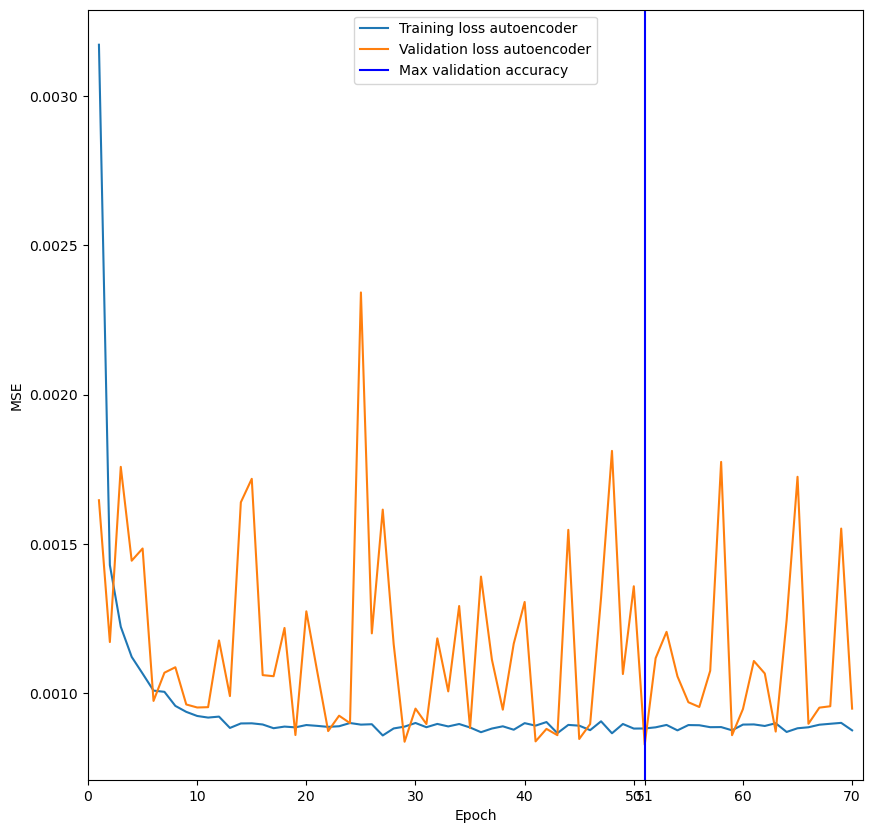

In [70]:
#generating the batch indexes
batchID = np.array([i+1 for i in range(len(train_ae))])

plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_ae,label = "Training loss autoencoder")
plt.plot(batchID,val_ae, label = "Validation loss autoencoder")
plt.xlabel("Epoch")
plt.ylabel("MSE")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])

#limit the plot x-values
plt.xticks(ticks)

plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig(str(mse_weight)+"_training-val_mse")
plt.show()

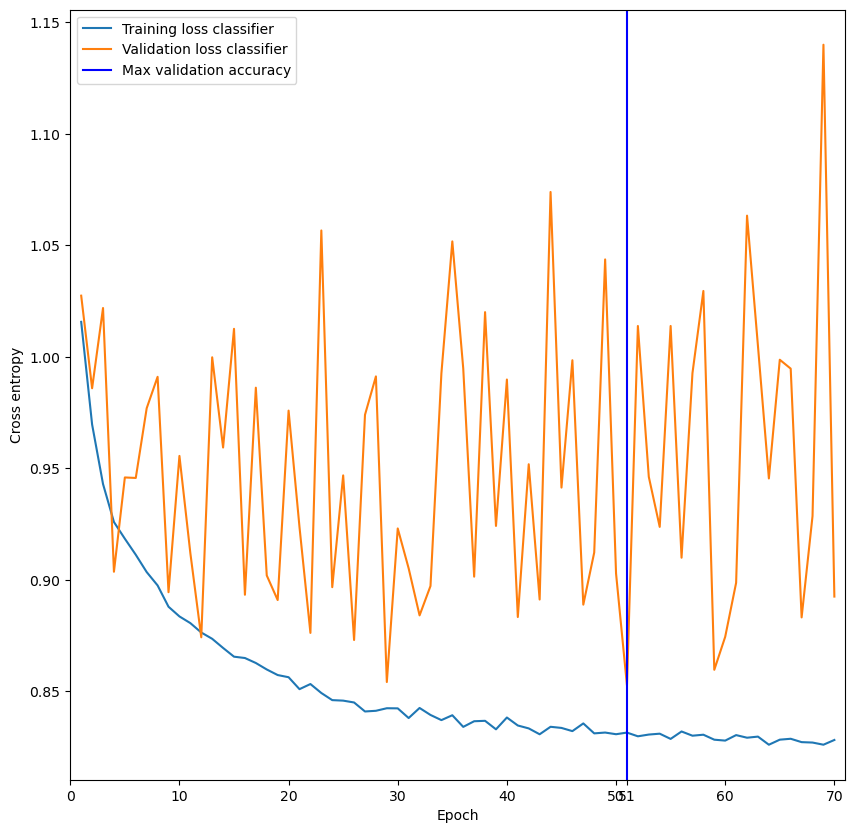

In [71]:
plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_c,label = "Training loss classifier")
plt.plot(batchID,val_c, label = "Validation loss classifier")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)

#limit the plot x-values
plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig(str(mse_weight)+"_train-val_ce")
plt.show()

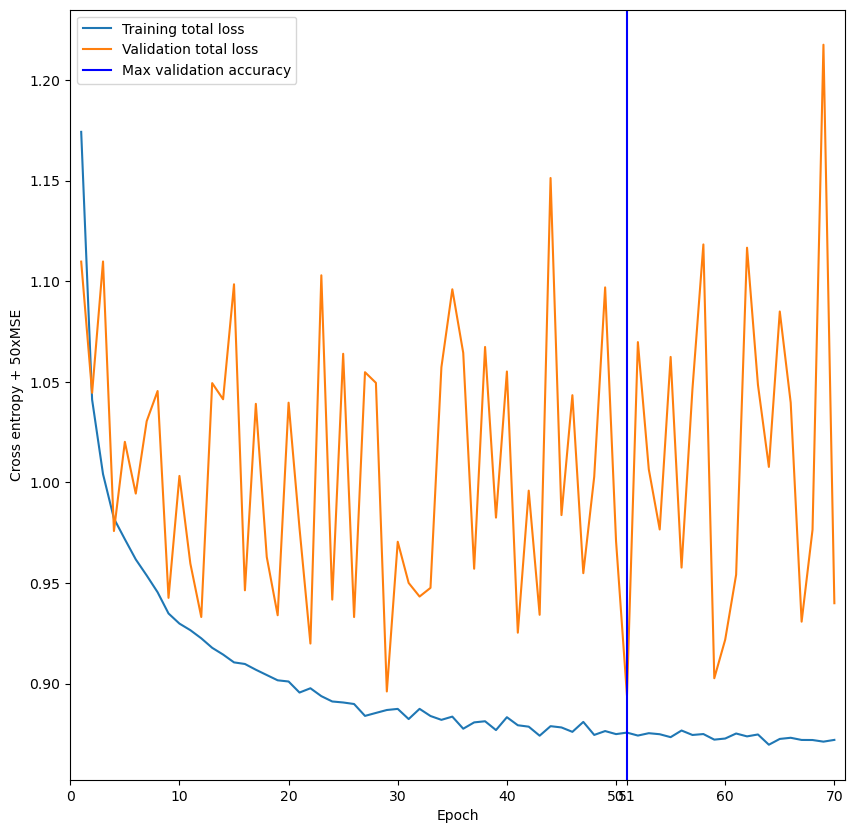

In [72]:
plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_c+mse_weight*np.ones(len(batchID))*train_ae,label = "Training total loss")
plt.plot(batchID,val_c+mse_weight*np.ones(len(batchID))*val_ae, label = "Validation total loss")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy + "+str(mse_weight)+"xMSE")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)

#limit the plot x-values
plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig(str(mse_weight)+"_train-val_totalloss")
plt.show()

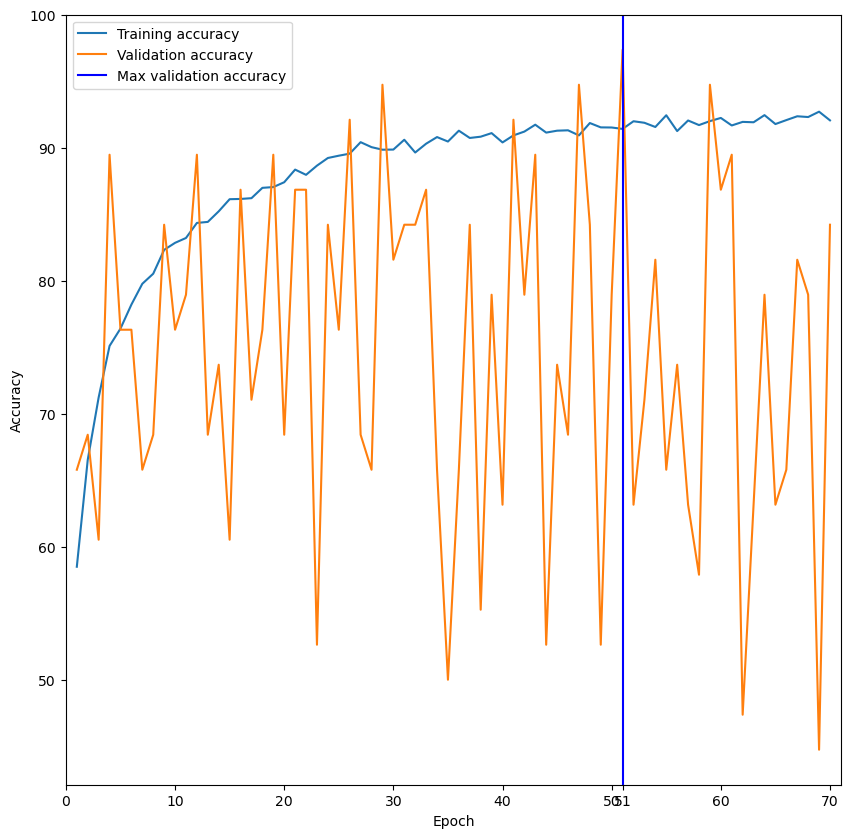

In [73]:
plt.figure(figsize=(10,10))

#plotting the accuracy
plt.plot(batchID,train_acc,label = "Training accuracy")
plt.plot(batchID,val_acc, label = "Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)

#limit the plot x-values
plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig(str(mse_weight)+"_train-val_accuracy")
plt.show()

### Test

Notice that the value of the losses and the accuracy for the train set are computed during the training, so they are not very accurate.

In [74]:
def print_confusion_matrix_pandas(labels,predictions,title,save_img = False):
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels, y_pred=predictions)
    # Plot the confusion matrix as an image.
    class_names = name_to_id.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    #plt.axis([-0.5, 13.5, 13.5, -0.5])
    plt.title(title,fontsize=20)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    if save_img:
        plt.savefig("./"+title+".png")
    plt.show()
    
    return cm

In [75]:
train_dir = os.path.join(data_dir,"train","images")#images
train_dir_patches = os.path.join(data_dir,"train","images_patch")#patches
train_labels_dir = os.path.join(data_dir,"train","labels","train.json")
with open(train_labels_dir) as f:
    train_labels = json.load(f)#labels

train_dataset = HDAdatasetPatches(train_dir,train_dir_patches,train_labels,train = False,
                          grayscale=grayscale,fft=fft)

In [ ]:
_,_,_,real_train,pred_train = test(train_dataset,"TRAIN")
_,_,_,real_val,pred_val = test(val_dataset,"VALIDATION")
_,_,_,real_test,pred_test = test(test_dataset,"TEST");

TRAIN set: 100%|█████████████████████████████████████████████████████████████████████| 261/261 [01:23<00:00,  3.11it/s]


TRAIN: Autoencoder Loss: 0.0008, Classifier Loss: 0.8486, Accuracy: 94.6360 in 261 input samples



VALIDATION set:  82%|█████████████████████████████████████████████████████▊            | 31/38 [00:09<00:02,  3.24it/s]

In [ ]:
confusion_train = print_confusion_matrix_pandas(real_train,pred_train,"Train set",save_img = False)
print_confusion_matrix_pandas(real_val,pred_val,"Validation set",save_img = False)
print_confusion_matrix_pandas(real_test,pred_test,"Test set",save_img = False);

In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = fig.add_gridspec(2,10)
gs2 = gs[1,:].subgridspec(4,10)

pred=[]
labels = torch.tensor(test_dataset[ids][1]).to(device)
true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]

count = {0:0,1:0,2:0}

for i,patch in enumerate(test_dataset[ids][0]):
    
    ax = fig.add_subplot(gs2[i])
    
    
    img = torch.tensor(patch).to(device)

    rec_img,pred_labels= autoencoder(img)  
    
    
    curr = pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0]
    
    count[curr] = count[curr]+1
    
    pred.append(curr)
    
    ax.set_title(" pred: "+r"$\bf{" + id_to_name[curr]  + "}$",fontsize=15)
    
    imagergb = cv2.cvtColor(patch.reshape(3,128,128).transpose(1,2,0), cv2.COLOR_BGR2RGB)
    ax.imshow(imagergb)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if(true_image_label == curr):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('green')    # change color
    else:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('red')    # change color

final_image_label = max(set(pred), key=pred.count) 


ax = fig.add_subplot(gs[0,:])
ax.set_title("true: "+r"$\bf{" + id_to_name[true_image_label]  + "}$"+ " pred: "+r"$\bf{" + id_to_name[final_image_label]  + "}$", fontsize=15)
ax.imshow(test_dataset[ids][2])

ax.text(test_dataset[ids][2].shape[1]+15,15,"Patches count:", fontsize=20,weight='bold')
ax.text(test_dataset[ids][2].shape[1]+15,45,id_to_name[0]+": "+str(count[0]), fontsize=20)
ax.text(test_dataset[ids][2].shape[1]+15,75,id_to_name[1]+": "+str(count[1]), fontsize=20)
ax.text(test_dataset[ids][2].shape[1]+15,105,id_to_name[2]+": "+str(count[2]), fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

if(true_image_label == final_image_label):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('green')    # change color
else:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('red')    # change color

In [ ]:
ids2 = 10 #use another input example 
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = fig.add_gridspec(2,10)
gs2 = gs[1,:].subgridspec(4,10)

pred=[]
labels = torch.tensor(test_dataset[ids2][1]).to(device)
true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]

count = {0:0,1:0,2:0}

for i,patch in enumerate(test_dataset[ids2][0]):
    
    ax = fig.add_subplot(gs2[i])
    
    
    img = torch.tensor(patch).to(device)

    rec_img,pred_labels= autoencoder(img)  
    
    
    curr = pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0]
    
    count[curr] = count[curr]+1
    
    pred.append(curr)
    
    ax.set_title(" pred: "+r"$\bf{" + id_to_name[curr]  + "}$",fontsize=15)
    
    imagergb = cv2.cvtColor(patch.reshape(3,128,128).transpose(1,2,0), cv2.COLOR_BGR2RGB)
    ax.imshow(imagergb)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if(true_image_label == curr):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('green')    # change color
    else:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('red')    # change color

final_image_label = max(set(pred), key=pred.count) 




ax = fig.add_subplot(gs[0,:])
ax.set_title("true: "+r"$\bf{" + id_to_name[true_image_label]  + "}$"+ " pred: "+r"$\bf{" + id_to_name[final_image_label]  + "}$", fontsize=15)
ax.imshow(test_dataset[ids2][2])

ax.text(test_dataset[ids2][2].shape[1]+15,15,"Patches count:", fontsize=20,weight='bold')
ax.text(test_dataset[ids2][2].shape[1]+15,45,id_to_name[0]+": "+str(count[0]), fontsize=20)
ax.text(test_dataset[ids2][2].shape[1]+15,75,id_to_name[1]+": "+str(count[1]), fontsize=20)
ax.text(test_dataset[ids2][2].shape[1]+15,105,id_to_name[2]+": "+str(count[2]), fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

if(true_image_label == final_image_label):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('green')    # change color
else:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('red')    # change color

### Solution to the "same count problem"

In [ ]:
ids2 = 68 #use another input example 
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = fig.add_gridspec(2,10)
gs2 = gs[1,:].subgridspec(4,10)

pred=[]
labels = torch.tensor(test_dataset[ids2][1]).to(device)
true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]

count = {0:0,1:0,2:0}

for i,patch in enumerate(test_dataset[ids2][0]):
    
    ax = fig.add_subplot(gs2[i])
    
    
    img = torch.tensor(patch).to(device)

    rec_img,pred_labels= autoencoder(img)  
    
    
    curr = pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0]
    
    count[curr] = count[curr]+1
    
    pred.append(curr)
    
    ax.set_title(" pred: "+r"$\bf{" + id_to_name[curr]  + "}$",fontsize=15)
    
    imagergb = cv2.cvtColor(patch.reshape(3,128,128).transpose(1,2,0), cv2.COLOR_BGR2RGB)
    ax.imshow(imagergb)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if(true_image_label == curr):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('green')    # change color
    else:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('red')    # change color

final_image_label = max(set(pred), key=pred.count) 




ax = fig.add_subplot(gs[0,:])
ax.set_title("true: "+r"$\bf{" + id_to_name[true_image_label]  + "}$"+ " pred: "+r"$\bf{" + id_to_name[final_image_label]  + "}$", fontsize=15)
ax.imshow(test_dataset[ids2][2])

ax.text(test_dataset[ids2][2].shape[1]+15,15,"Patches count:", fontsize=20,weight='bold')
ax.text(test_dataset[ids2][2].shape[1]+15,45,id_to_name[0]+": "+str(count[0]), fontsize=20)
ax.text(test_dataset[ids2][2].shape[1]+15,75,id_to_name[1]+": "+str(count[1]), fontsize=20)
ax.text(test_dataset[ids2][2].shape[1]+15,105,id_to_name[2]+": "+str(count[2]), fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

if(true_image_label == final_image_label):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('green')    # change color
else:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('red')    # change color

To solve this problem is quite simple: looking at the confusion matrix of the train set we can compare the probability of wrong prediction beetween two classes with the same count:<br>
if the probability to confuse the class1(the predicted class) with the class2(the class with the same count of class1) is higher then the vice versa, you sobstitute the prediction class1 with the class2. 

In [ ]:
def test_modified(dataset,name,confusion_matrix):
    
    losses_ae = []
    losses_c = []
    count_correct = 0
    count_input = 0
    
    real_labels = []
    predicted_labels = []
    

    autoencoder.eval()
    
    #single image
    for data in tqdm(dataset,desc = name +" set"):
        pred = []
        labels = torch.tensor(data[1]).to(device)
        
        #iterate over all the patches
        for patch in data[0]:
            
            img = torch.tensor(patch).to(device)
            
            rec_img,pred_labels= autoencoder(img)  
            
            classifier_loss = criterion_classifier(pred_labels, labels)
            ae_loss= criterion_ae(img,rec_img)
            

            losses_ae.append(ae_loss.detach().cpu().numpy())
            losses_c.append(classifier_loss.detach().cpu().numpy())
            
            pred.append(pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0])
            
            
        count_input += 1
        
#####modified part of the test function################

        counter = dict(Counter(pred)) #dictionari of class:count
        
        final_image_label = max(counter, key=counter.get) #extract the label with the max count
        max_value = counter[final_image_label] #extract the count of that label
        
        del counter[final_image_label] #remove the entry with the max count (now you can easily extract the second prediction
                                       # using the same procedure)*
        
        if len(counter.keys())!=0: #*but only if there are other possible prediction (some samples are hard classified 
                                #,i.e. all 40 patches with the same predicted class)
        
            second_prediction = max(counter, key=counter.get)
            second_max_value = counter[second_prediction]

            if second_max_value == max_value: #if the two counts are the same
                
                count_wrong_12 = confusion_matrix[second_prediction,final_image_label] #confuse prediction with second class
                count_wrong_21 = confusion_matrix[final_image_label,second_prediction] #confuse second class with prediction
                if count_wrong_12 < count_wrong_21 : #comparing the two probabilities 
                    final_image_label = second_prediction #sobstitute prediction with the second predicted class                    
######################################################################### 

        true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]
        
        
        count_correct+= (final_image_label == true_image_label)
        
        del img
        del labels
        torch.cuda.empty_cache()
        gc.collect();
        
        predicted_labels.append(final_image_label)
        real_labels.append(true_image_label)
        

    # Print loss at end of each epoch
    accuracy= (count_correct/count_input)*100.
    print(name+': Autoencoder Loss: %.4f, Classifier Loss: %.4f, Accuracy: %.4f in %d input samples\n'
      % (np.mean(losses_ae), np.mean(losses_c),accuracy,count_input))
    
    return np.mean(losses_ae),np.mean(losses_c),accuracy,real_labels,predicted_labels

In [ ]:
_,_,_,real_val,pred_val = test_modified(train_dataset,"TRAIN",confusion_train);
_,_,_,real_val,pred_val = test_modified(val_dataset,"VALIDATION",confusion_train);
_,_,_,real_test,pred_test = test_modified(test_dataset,"TEST",confusion_train);

In [ ]:
print_confusion_matrix_pandas(real_val,pred_val,"Train set",save_img = False)
print_confusion_matrix_pandas(real_val,pred_val,"Validation set",save_img = False)
print_confusion_matrix_pandas(real_test,pred_test,"Test set",save_img = False);

In [ ]:
ids2 = 68  
fig = plt.figure(constrained_layout=True,figsize=(20,20))
gs = fig.add_gridspec(2,10)
gs2 = gs[1,:].subgridspec(4,10)

pred=[]
labels = torch.tensor(test_dataset[ids2][1]).to(device)
true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]

count = {0:0,1:0,2:0}

for i,patch in enumerate(test_dataset[ids2][0]):
    
    ax = fig.add_subplot(gs2[i])
    
    
    img = torch.tensor(patch).to(device)

    rec_img,pred_labels= autoencoder(img)  
    
    
    curr = pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0]
    
    count[curr] = count[curr]+1
    
    pred.append(curr)
    
    ax.set_title(" pred: "+r"$\bf{" + id_to_name[curr]  + "}$",fontsize=15)
    
    imagergb = cv2.cvtColor(patch.reshape(3,128,128).transpose(1,2,0), cv2.COLOR_BGR2RGB)
    ax.imshow(imagergb)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if(true_image_label == curr):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('green')    # change color
    else:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(4)  # change width
            ax.spines[axis].set_color('red')    # change color

    counter = dict(Counter(pred))

    final_image_label = max(counter, key=counter.get)
    max_value = counter[final_image_label]

    del counter[final_image_label]

    if len(counter.keys())!=0:

        second_prediction = max(counter, key=counter.get)
        second_max_value = counter[second_prediction]

        if second_max_value == max_value:
            count_wrong = confusion_train[second_prediction,final_image_label]
            if count_wrong < confusion_train[final_image_label,second_prediction]:
                final_image_label = second_prediction 


ax = fig.add_subplot(gs[0,:])
ax.set_title("true: "+r"$\bf{" + id_to_name[true_image_label]  + "}$"+ " pred: "+r"$\bf{" + id_to_name[final_image_label]  + "}$", fontsize=15)
ax.imshow(test_dataset[ids2][2])

ax.text(test_dataset[ids2][2].shape[1]+15,15,"Patches count:", fontsize=20,weight='bold')
ax.text(test_dataset[ids2][2].shape[1]+15,45,id_to_name[0]+": "+str(count[0]), fontsize=20)
ax.text(test_dataset[ids2][2].shape[1]+15,75,id_to_name[1]+": "+str(count[1]), fontsize=20)
ax.text(test_dataset[ids2][2].shape[1]+15,105,id_to_name[2]+": "+str(count[2]), fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

if(true_image_label == final_image_label):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('green')    # change color
else:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(8)  # change width
        ax.spines[axis].set_color('red')    # change color

## Comparison without the decoder during the training

In [ ]:
if (LOAD_MODEL): #the model trained without the decoder is avaible in the folder downloaded
    
    #load the model an the results
    autoencoder.load_state_dict(torch.load(os.path.join(models_dir,"0_best_ae.pt")))
    autoencoder.eval();
    
    mse_weight = 0 #the loaded model use a mse_weight = 50
    results = np.load(os.path.join(models_dir,"50_results.npy"),allow_pickle=True)
    
    #train
    train_ae = results[0][0] #mse
    train_c = results[0][1] #cross entropy
    train_acc = results[0][2] #accuracy

    #validation
    val_ae = results[1][0] #mse
    val_c = results[1][1] #cross entropy
    val_acc = results[1][2] #accuracy

    #best epoch number
    best_epoch = results[2]
    
    #generating the batch indexes
    batchID = np.array([i+1 for i in range(len(train_ae))])
    
    ######AUTOENCODER LOSS#######
    plt.figure(figsize=(10,10))

    #plotting the losses
    plt.plot(batchID,train_ae,label = "Training loss autoencoder")
    plt.plot(batchID,val_ae, label = "Validation loss autoencoder")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")

    #showing the position of the best values
    plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

    #adding the position of the best values in the x axis
    ticks = list(plt.xticks()[0]) 
    ticks.extend([best_epoch])

    #limit the plot x-values
    plt.xticks(ticks)

    plt.xlim(0,batchID.max()+1)

    plt.legend()

    #saving the figure
    #plt.savefig(str(mse_weight)+"_training-val_mse")
    plt.show()
    
    
    ######CLASSIFIER LOSS#######
    plt.figure(figsize=(10,10))

    #plotting the losses
    plt.plot(batchID,train_c,label = "Training loss classifier")
    plt.plot(batchID,val_c, label = "Validation loss classifier")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy")

    #showing the position of the best values
    plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

    #adding the position of the best values in the x axis
    ticks = list(plt.xticks()[0]) 
    ticks.extend([best_epoch])
    plt.xticks(ticks)

    #limit the plot x-values
    plt.xlim(0,batchID.max()+1)

    plt.legend()

    #saving the figure
    #plt.savefig(str(mse_weight)+"_train-val_ce")
    plt.show()
    
    
    ######TOTAL LOSS#######
    plt.figure(figsize=(10,10))

    #plotting the losses
    plt.plot(batchID,train_c+mse_weight*np.ones(len(batchID))*train_ae,label = "Training total loss")
    plt.plot(batchID,val_c+mse_weight*np.ones(len(batchID))*val_ae, label = "Validation total loss")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy + "+str(mse_weight)+"xMSE")

    #showing the position of the best values
    plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

    #adding the position of the best values in the x axis
    ticks = list(plt.xticks()[0]) 
    ticks.extend([best_epoch])
    plt.xticks(ticks)

    #limit the plot x-values
    plt.xlim(0,batchID.max()+1)

    plt.legend()

    #saving the figure
    #plt.savefig(str(mse_weight)+"_train-val_totalloss")
    plt.show()
    
    
    ######ACCURACY#######
    plt.figure(figsize=(10,10))

    #plotting the accuracy
    plt.plot(batchID,train_acc,label = "Training accuracy")
    plt.plot(batchID,val_acc, label = "Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    #showing the position of the best values
    plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

    #adding the position of the best values in the x axis
    ticks = list(plt.xticks()[0]) 
    ticks.extend([best_epoch])
    plt.xticks(ticks)

    #limit the plot x-values
    plt.xlim(0,batchID.max()+1)

    plt.legend()

    #saving the figure
    #plt.savefig(str(mse_weight)+"_train-val_accuracy")
    plt.show()
    
    ######TESTING WITHOUT THE INFORMATION PROVIDED BY THE TRAIN CONFUSION MATRIX#######
    _,_,_,real_train,pred_train = test(train_dataset,"TRAIN")
    _,_,_,real_val,pred_val = test(val_dataset,"VALIDATION")
    _,_,_,real_test,pred_test = test(test_dataset,"TEST");
    
    print_confusion_matrix_pandas(real_val,pred_val,"Train set",save_img = False)
    print_confusion_matrix_pandas(real_val,pred_val,"Validation set",save_img = False)
    print_confusion_matrix_pandas(real_test,pred_test,"Test set",save_img = False);
    
    
    ######TESTING WITH THE INFORMATION PROVIDED BY THE TRAIN CONFUSION MATRIX#######
    _,_,_,real_val,pred_val = test_modified(train_dataset,"TRAIN",confusion_train);
    _,_,_,real_val,pred_val = test_modified(val_dataset,"VALIDATION",confusion_train);
    _,_,_,real_test,pred_test = test_modified(test_dataset,"TEST",confusion_train);
    
    print_confusion_matrix_pandas(real_val,pred_val,"Train set",save_img = False)
    print_confusion_matrix_pandas(real_val,pred_val,"Validation set",save_img = False)
    print_confusion_matrix_pandas(real_test,pred_test,"Test set",save_img = False);